># Multilingual Telegram-Bot Based on a Large Language Model with Mathematical Reasoning

## HSE MDS Thesis Paper Code

---
---

In [1]:
#@title 🎵  Silent Audio Player { display-mode: "form" }

#@markdown 👇 Running the audio player below will prevent Colab from disconnecting this notebook from the runtime due to inactivity.
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

## 1. Dependencies and prerequisites

In [2]:
# ! CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install -q llama-cpp-python

In [3]:
%%capture
#@title Installung Unsloth, Xformers (Flash Attention) and other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes datasets
!pip install aiogram

In [4]:
import torch
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer
from transformers import TrainingArguments, set_seed
from datasets import Dataset, load_dataset

from tqdm.notebook import tqdm

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [5]:
import pandas as pd
import numpy as np
import random
import gc
import re
import os

In [6]:
#@title Random seed setting

#----------------------------------------------------#
seed_val = 225
#----------------------------------------------------#


def seed_setting(seed_val):
    set_seed(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.random.manual_seed(seed_val)
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)  # if using multi-GPU.
    os.environ['PYTHONHASHSEED'] = str(seed_val)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True


seed_setting(seed_val)

In [7]:
#@title Mounting Google Drive
from google.colab import drive, userdata

try:
    GDRIVE_WORKDIR = '/content/drive/MyDrive/_thesis_paper'
    %cd $GDRIVE_WORKDIR
except Exception as err:
    if not os.path.isdir('drive'): drive.mount('/content/drive')
    GDRIVE_WORKDIR = '/content/drive/MyDrive/_thesis_paper'
    %cd $GDRIVE_WORKDIR

/content/drive/MyDrive/_thesis_paper


In [ ]:
if not os.path.isdir('MathOctopus'):
    !git clone https://github.com/microsoft/MathOctopus MathOctopus

In [ ]:
if not os.path.isdir('data'):
    !cp -r MathOctopus/step1_supervised_finetuning/data data

## 2. Data loading and preparing

In [ ]:
train_df_path = 'data/MGSM8KInstruct/MGSM8KInstruct_Parallel.json'
eval_df_path = 'data/mgsm'

In [ ]:
#@title Evaluation dataset

languages = ['English', 'Bengali', 'Chinese', 'French', 'German', 'Japanese', 'Russian', 'Spanish', 'Swahili', 'Thai']
eval_datasets = []

for language in languages:
    lang_df = pd.read_json(f'{eval_df_path}/mgsm_{language}.json', lines=True)
    lang_df['language'] = language
    eval_datasets.append(lang_df)
    lang_df = ''

eval_df = pd.concat(eval_datasets, ignore_index=True)

In [ ]:
eval_df.head()

,query,response,language
0,Janet’s ducks lay 16 eggs per day. She eats th...,18,English
1,A robe takes 2 bolts of blue fiber and half th...,3,English
2,Josh decides to try flipping a house. He buys...,70000,English
3,James decides to run 3 sprints 3 times a week....,540,English
4,"Every day, Wendi feeds each of her chickens th...",20,English


In [ ]:
#@title Evaluation dataset conversion
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['query', 'response', 'language'],
    num_rows: 2500
})

In [ ]:
#@title Train dataset
train_df = pd.read_json(train_df_path, lines=True)
train_df.shape

(73559, 3)

In [ ]:
train_df.head()

,prompt,chosen,reject
0,Below is an instruction that describes a task....,The number of clips sold in April is 48/2 = <<...,I don't know.
1,Below is an instruction that describes a task....,নাতালিয়া মে মাসে 48/2 = <<48/2=24>>24 টি ক্ল...,I don't know.
2,Below is an instruction that describes a task....,Natalia hat im Mai 48/2 = <<48/2=24>>24 Clips...,I don't know.
3,Below is an instruction that describes a task....,El número de clips vendidos en abril es 48/2 ...,I don't know.
4,Below is an instruction that describes a task....,Avril : 48\nMai : 48/2 = <<48/2=24>>24\n48 + ...,I don't know.


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73559 entries, 0 to 73558
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  73559 non-null  object
 1   chosen  73559 non-null  object
 2   reject  73559 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
train_df.describe()

,prompt,chosen,reject
count,73559,73559,73559
unique,73558,73559,1
top,Below is an instruction that describes a task....,ถ้าหากว่าอานิก้ามีอายุ 30 ปีในปัจจุบัน ในอีก ...,I don't know.
freq,2,1,73559


In [ ]:
#@title Deleting unused columns, giving proper names
train_df = train_df[['prompt', 'chosen']]
train_df.columns = ['prompt', 'completion']

In [ ]:
#@title Sample data
idx = 0
print(train_df.prompt[idx])
print(train_df.completion[idx])

Below is an instruction that describes a task. Write a response that appropriately completes the request in English. Please answer in English.

### Instruction:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

### Response:
The number of clips sold in April is 48/2 = <<48/2=24>>24.
Natalia sold 24 + 48 = <<24+48=72>>72 clips altogether in April and May.
#### 72


In [ ]:
#@title Replacing characters causing error while HTML parsing
train_df.completion = train_df.completion.str.replace("<<", "|").str.replace(">>", "|")

In [ ]:
#@title Correcting an accidentially noticed error in completion
train_df.completion[idx]

'The number of clips sold in April is 48/2 = |48/2=24|24.\nNatalia sold 24 + 48 = |24+48=72|72 clips altogether in April and May.\n#### 72'

In [ ]:
train_df.completion[idx] = """The number of clips sold in May is 48/2 = |48/2=24|24.
Natalia sold 24 + 48 = |24+48=72|72 clips altogether in April and May.
#### 72"""

In [ ]:
train_df.completion[idx]

'The number of clips sold in May is 48/2 = |48/2=24|24.\nNatalia sold 24 + 48 = |24+48=72|72 clips altogether in April and May.\n#### 72'

In [ ]:
#@title Building up formatted prompts
train_df['formatted_prompt'] = train_df.prompt[0] + '\n' +  train_df.completion[0] + '<|end_of_text|>'

In [ ]:
train_df.head()

,prompt,completion,formatted_prompt
0,Below is an instruction that describes a task....,The number of clips sold in May is 48/2 = |48/...,Below is an instruction that describes a task....
1,Below is an instruction that describes a task....,নাতালিয়া মে মাসে 48/2 = |48/2=24|24 টি ক্লিপ...,Below is an instruction that describes a task....
2,Below is an instruction that describes a task....,Natalia hat im Mai 48/2 = |48/2=24|24 Clips v...,Below is an instruction that describes a task....
3,Below is an instruction that describes a task....,El número de clips vendidos en abril es 48/2 ...,Below is an instruction that describes a task....
4,Below is an instruction that describes a task....,Avril : 48\nMai : 48/2 = |48/2=24|24\n48 + 24...,Below is an instruction that describes a task....


In [ ]:
#@title Formatted prompt sample
train_df.formatted_prompt[idx]

'Below is an instruction that describes a task. Write a response that appropriately completes the request in English. Please answer in English.\n\n### Instruction:\nNatalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\n### Response:\nThe number of clips sold in May is 48/2 = |48/2=24|24.\nNatalia sold 24 + 48 = |24+48=72|72 clips altogether in April and May.\n#### 72<|end_of_text|>'

In [ ]:
#@title Train dataset conversion
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['prompt', 'completion', 'formatted_prompt'],
    num_rows: 73559
})

## 3. Settings and initializations

In [ ]:
from huggingface_hub import login
login(token=userdata.get('hugging_face'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#@title Model download

from huggingface_hub import snapshot_download, hf_hub_download

model_paths = {
    '_model_MathOctopus_Parallel_7B': 'Mathoctopus/Parallel_7B',
    '_model_llama_3_8B_Instruct_meta': 'meta-llama/Meta-Llama-3-8B-Instruct',
    '_model_llama_2_7B_chat_hf_meta': 'meta-llama/Llama-2-7b-chat-hf',
    '_model_Llama-3-8B-Instruct-v0.5_MP': 'MaziyarPanahi/Llama-3-8B-Instruct-v0.5',
    '_model_llama_3_8B_Instruct_GGUF': [
        ('bartowski/Meta-Llama-3-8B-Instruct-GGUF', 'Meta-Llama-3-8B-Instruct-Q8_0.gguf', None)
        ],
    '_model_llama_3_70B_Instruct_GGUF': [
        ('bartowski/Meta-Llama-3-70B-Instruct-GGUF', 'Meta-Llama-3-70B-Instruct-Q6_K-00001-of-00002.gguf', 'Meta-Llama-3-70B-Instruct-Q6_K.gguf'),
        ('bartowski/Meta-Llama-3-70B-Instruct-GGUF', 'Meta-Llama-3-70B-Instruct-Q6_K-00002-of-00002.gguf', 'Meta-Llama-3-70B-Instruct-Q6_K.gguf')
        ]
}


for model_path, model_repo in model_paths.items():
    if os.path.isdir(model_path):
        print(f'Target exists. Skipping for local dir {model_path}')
    else:
        print(f'>>> {model_path}')
        if type(model_repo) == list:
            for model_file in model_repo:
                hf_hub_download(repo_id=model_file[0], filename=model_file[1], subfolder=model_file[2], local_dir=model_path)
        else:
            snapshot_download(repo_id=model_repo, local_dir=model_path)


Target exists. Skipping for local dir _model_MathOctopus_Parallel_7B
Target exists. Skipping for local dir _model_llama_3_8B_Instruct_meta
Target exists. Skipping for local dir _model_llama_2_7B_chat_hf_meta
Target exists. Skipping for local dir _model_Llama-3-8B-Instruct-v0.5_MP
Target exists. Skipping for local dir _model_llama_3_8B_Instruct_GGUF
Target exists. Skipping for local dir _model_llama_3_70B_Instruct_GGUF


In [ ]:
ls

code/
data/
inbox225710/
MathOctopus/
_model_llama_2_7B_chat_hf_meta/
_model_llama_3_70B_Instruct_GGUF/
_model_llama_3_8B_Instruct_GGUF/
_model_llama_3_8B_Instruct_meta/
_model_llama_3_8B_Instruct_meta_e0s1200_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s1200_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s1600_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s1600_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r256_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r256_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2500_b4_g4_r256_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2500_b4_g4_r256_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e1s0_b4_g4_r256_a1_lr1e-05_rslFalse/
_model_llama_3_8B_Instruct

In [ ]:
#----------------------------------------------------#
#@title +++ Settings and parameters
#----------------------------------------------------#


max_seq_length = 512
dtype = None # 'Float16' | 'Bfloat16'  # None for autodetection
load_in_4bit = False

# LoRA parameters
lora_rank = 480 # LoRA attention dimension, suggested 8, 16, 32, 64, 128
target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'] # names of the modules to apply the adapter to
lora_alpha = 1 # alpha parameter for LoRA scaling
lora_dropout = 0 # dropout probability for LoRA layers
bias  = 'none'
use_gradient_checkpointing = True # True or 'unsloth' for very long context
use_rslora = False # use rank stabilized LoRA
loftq_config = None # use LoFTQ technique


# SFTTrainer parameters
dataset_text_field = 'formatted_prompt'
dataset_num_proc = 2 # not used when packing=True
packing = False


# SFTTrainer training arguments
per_device_train_batch_size = 4
max_steps = 0
num_train_epochs = 1
save_strategy = 'no'
logging_steps = 100
output_dir = 'output'


learning_rate = 1e-5
lr_scheduler_type = 'cosine'
warmup_steps = 0
optimizer_name = 'adamw_torch'
weight_decay = 0.0
adam_beta1 = 0.9
adam_beta2 = 0.95
gradient_accumulation_steps = 4

In [ ]:
#@title Initialization of model and tokenizer

def initialize(model_name, max_seq_length, load_in_4bit, dtype=None):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name, max_seq_length, dtype, load_in_4bit
    )

    tokenizer.padding_side = 'left'
    return model, tokenizer

In [ ]:
model_path = '_model_llama_3_8B_Instruct_meta'

#----------------------------------------------------#
do_SFT_trainig = True
save_to_local = do_SFT_trainig
save_to_hub = False
#----------------------------------------------------#

if do_SFT_trainig:
    model_save_path = f'{model_path}_e{num_train_epochs}s{max_steps}_b{per_device_train_batch_size}_g{gradient_accumulation_steps}_r{lora_rank}_a{lora_alpha}_lr{learning_rate}_rsl{use_rslora}'
else:
    model_save_path = model_path

In [ ]:
model, tokenizer = initialize(model_name=model_path, max_seq_length=max_seq_length, load_in_4bit=load_in_4bit)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
_model_llama_3_8B_Instruct_meta does not have a padding token! Will use pad_token = <|reserved_special_token_250|>.


In [ ]:
from typing import Iterable, Tuple

def validate_expected_param_dtype(
    named_params: Iterable[Tuple[str, torch.nn.Parameter]], dtype: torch.dtype
) -> None:
    dtypes = []
    for name, param in named_params:
        dtypes.append(param.dtype == dtype)
    if (sum(dtypes) == len(dtypes)):
        print('bfloat', len(dtypes))
    elif (sum(dtypes) == 0):
        print('float')
    else:
        print('mixed')

In [ ]:
validate_expected_param_dtype(model.named_parameters(), torch.bfloat16)

bfloat 291


In [ ]:
#@title LoRA

if do_SFT_trainig:
    model = FastLanguageModel.get_peft_model(
        model,
        r = lora_rank,
        target_modules = target_modules,
        lora_alpha = lora_alpha,
        lora_dropout = lora_dropout,
        bias = bias,
        use_gradient_checkpointing = use_gradient_checkpointing,
        random_state = seed_val,
        use_rslora = use_rslora,
        loftq_config = loftq_config
    )

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
#@title Supervised Fine-Tuning Trainer

if do_SFT_trainig:
    trainer = SFTTrainer(
        model = model,
        tokenizer = tokenizer,
        train_dataset = train_dataset,
        dataset_text_field = dataset_text_field,
        max_seq_length = max_seq_length,
        dataset_num_proc = dataset_num_proc,
        packing = packing,
        args = TrainingArguments(
            per_device_train_batch_size = per_device_train_batch_size,
            gradient_accumulation_steps = gradient_accumulation_steps,
            warmup_steps = warmup_steps,
            max_steps = max_steps,
            num_train_epochs = num_train_epochs,
            learning_rate = learning_rate,
            fp16 = not is_bfloat16_supported(),
            bf16 = is_bfloat16_supported(),
            logging_steps = logging_steps,
            optim = optimizer_name,
            weight_decay = weight_decay,
            lr_scheduler_type = lr_scheduler_type,
            seed = seed_val,
            save_strategy = save_strategy,
            output_dir = output_dir
        )
    )

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/73559 [00:00<?, ? examples/s]

## 4. Model fine-tuning

In [ ]:
#@title Current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
19.787 GB of memory reserved.


In [ ]:
#@title Training run
if do_SFT_trainig: trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 73,559 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 4,597
 "-____-"     Number of trainable parameters = 1,258,291,200


Step,Training Loss
100,2.301500
200,1.206700
300,0.139800
400,0.063300
500,0.040100
600,0.013700
700,0.003800
800,0.002100
900,0.001400
1000,0.001000


In [ ]:
#@title Final memory and time stats
if do_SFT_trainig:
    used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
    used_percentage = round(used_memory         /max_memory*100, 3)
    lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
    print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
    print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
    print(f"Peak reserved memory = {used_memory} GB.")
    print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
    print(f"Peak reserved memory % of max memory = {used_percentage} %.")
    print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

7861.1741 seconds used for training.
131.02 minutes used for training.
Peak reserved memory = 38.736 GB.
Peak reserved memory for training = 18.949 GB.
Peak reserved memory % of max memory = 97.907 %.
Peak reserved memory for training % of max memory = 47.895 %.


## 5. Model saving and loading

In [ ]:
#@title Local LoRA saving
if do_SFT_trainig:
    lora_path = model_save_path + '_lora'
    model.save_pretrained(lora_path)
    tokenizer.save_pretrained(lora_path)

In [ ]:
#@title Loading finetuned LoRA
# // True to enable

if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = lora_path, # trained model
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )

In [ ]:
#@title Saving to float16
if save_to_local: model.save_pretrained_merged(model_save_path, tokenizer, save_method = 'merged_16bit',)
if save_to_hub:
    from huggingface_hub import create_repo
    login(token=userdata.get('hugging_face_w'))
    create_repo(model_save_path)
    model.push_to_hub_merged(model_save_path, tokenizer, save_method = 'merged_16bit', token = userdata.get('hugging_face_w'))

Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 53.99 out of 83.48 RAM for saving.


100%|██████████| 32/32 [01:06<00:00,  2.08s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Done.


## 6. Testing

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request in {language}.  Please answer in {language}.

### Instruction:
{instruction}

### Response:
{answer}"""

In [ ]:
#@title Inference function

def inference(model, tokenizer, inputs, language):
    FastLanguageModel.for_inference(model)

    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    inputs = [inputs] if type(inputs) != list else inputs
    inputs = [alpaca_prompt.format(language=language, instruction=instruction, answer='') for instruction in inputs]
    inputs = tokenizer(inputs, return_tensors = 'pt', padding = True).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=512, do_sample=False, use_cache=True, pad_token_id=tokenizer.eos_token_id, temperature=0.00)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return decoded

In [ ]:
#@title Extraction of the answer number

def extract_last_num(text: str) -> float:
    text = re.sub(r"(\d),(\d)", "\g<1>\g<2>", text) # 123,456
    res = re.findall(r"(\d+(\.\d+)?)", text)  # 123456.789
    if len(res) > 0:
        num_str = res[-1][0]
        return float(num_str)
    else:
        return 0.0

In [ ]:
#@title GPU VRAM flushing

def free_memory(object_names):
    for object_name in object_names: del object_name
    torch.cuda.empty_cache()
    gc.collect()
    gpu_memory = round(torch.cuda.memory_reserved() / 1024 / 1024 / 1024, 3)
    print(f'{gpu_memory} GB of memory reserved.')

def flush_vram():
    global model, tokenizer
    model, tokenizer = '', ''
    free_memory((model, tokenizer))

In [ ]:
# Manual flushing in case the VRAM is not empty
flush_vram()

In [ ]:
#@title Testing function

def testing(model, tokenizer, language_selection=languages, batch_size=50):
    model_responses = {}

    for language in tqdm(language_selection):
        print('>>>', language)
        lang_eval_dataset = eval_dataset.filter(lambda row: row['language']==language)
        model_responses[language] = []
        for idx in tqdm(range(0, lang_eval_dataset.num_rows, batch_size)):
            inputs = lang_eval_dataset[idx:idx+batch_size]['query']
            responses = inference(model, tokenizer, inputs, language)
            pred_responses = [extract_last_num(response) for response in responses]
            true_responses = [extract_last_num(response) for response in lang_eval_dataset[idx:idx+batch_size]['response']]
            model_responses[language].extend([(abs(pred_response - true_response) < 1e-3) for pred_response, true_response in zip(pred_responses, true_responses)])
            free_memory((inputs, responses, pred_responses, true_responses))
        model_responses[language] = sum(model_responses[language])/len(model_responses[language])
        free_memory((lang_eval_dataset))
    return model_responses


In [8]:
#@title +++ Main testing script
%%writefile code/testing_script.py

import numpy as np
import random
import argparse
import json
import re
import os

import torch
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import set_seed
from datasets import load_dataset

from tqdm.auto import tqdm


#----------------------------------------------------#
seed_val = 225
#----------------------------------------------------#
def seed_setting(seed_val):
    set_seed(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.random.manual_seed(seed_val)
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)  # if using multi-GPU
    os.environ['PYTHONHASHSEED'] = str(seed_val)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

seed_setting(seed_val)


#----------------------------------------------------#
#                      Arguments                     #
#----------------------------------------------------#
parser = argparse.ArgumentParser()
parser.add_argument("-m", "--model", type=str)

args = parser.parse_args()
model_name = args.model


#----------------------------------------------------#
#                      Settings                      #
#----------------------------------------------------#
workspace_dir = ''
eval_dataset_path = 'data/mgsm/'
read_file_prefix = 'mgsm_'
save_file_prefix = 'model_response_'
max_seq_length = 512
load_in_4bit = False
max_new_tokens = 512
padding = True
do_sample = False # False for temperature 0.0
temperature = 0.00
use_cache = True

batch_size = 50

languages = ['English', 'Bengali', 'Chinese', 'French', 'German', 'Japanese', 'Russian', 'Spanish', 'Swahili', 'Thai']
language_selection = languages[:1] + languages[2:-1]

alpaca_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request in {language}.  Please answer in {language}.

### Instruction:
{instruction}

### Response:
{answer}"""
#----------------------------------------------------#


def initialize(model_name, max_seq_length, load_in_4bit, dtype=None):
    model, tokenizer = FastLanguageModel.from_pretrained(model_name, max_seq_length, dtype, load_in_4bit)
    model.generation_config.pad_token_ids = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    return model, tokenizer


def inference(model, tokenizer, inputs, language):
    inputs = [inputs] if type(inputs) != list else inputs
    inputs = [alpaca_prompt.format(language=language, instruction=instruction, answer='') for instruction in inputs]
    inputs = tokenizer(inputs, return_tensors = 'pt', padding = padding).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=do_sample, use_cache=use_cache,
                             pad_token_id=tokenizer.eos_token_id, temperature=temperature)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return decoded


def extract_last_num(text: str) -> float:
    text = re.sub(r"(\d),(\d)", "\g<1>\g<2>", text) # 123,456
    res = re.findall(r"(\d+(\.\d+)?)", text)  # 123456.789
    if len(res) > 0:
        num_str = res[-1][0]
        return float(num_str)
    else:
        return 0.0


def testing(model, tokenizer, language_selection, batch_size):
    model_responses = {}

    for language in tqdm(language_selection):
        print('\n\n---', language)
        lang_eval_dataset = load_dataset('json', data_files=f'{eval_dataset_path}{read_file_prefix}{language}.json', split='train') # eval_dataset.filter(lambda row: row['language']==language)
        model_responses[language] = []
        for idx in tqdm(range(0, lang_eval_dataset.num_rows, batch_size)):
            inputs = lang_eval_dataset[idx:idx+batch_size]['query']
            responses = inference(model, tokenizer, inputs, language)
            pred_responses = [extract_last_num(response) for response in responses]
            true_responses = [extract_last_num(response) for response in lang_eval_dataset[idx:idx+batch_size]['response']]
            model_responses[language].extend([(abs(pred_response - true_response) < 1e-3) for pred_response, true_response in zip(pred_responses, true_responses)])
        model_responses[language] = sum(model_responses[language])/len(model_responses[language])
    return model_responses


print(f'\n>>> Testing {model_name}\n')
model, tokenizer = initialize(model_name=model_name, max_seq_length=max_seq_length, load_in_4bit=load_in_4bit)
model_responses = testing(model=model, tokenizer=tokenizer, language_selection=language_selection, batch_size=batch_size)

print(f'\n>>> Dumping results for {model_name} ... ', end='')
with open(f"{workspace_dir}{save_file_prefix}{model_name}.json", "w") as output_file:
    json.dump(model_responses, output_file)

print(f'Done\n')


Overwriting code/testing_script.py


In [9]:
ls

code/
data/
inbox225710/
MathOctopus/
_model_llama_2_7B_chat_hf_meta/
_model_llama_3_70B_Instruct_GGUF/
_model_llama_3_8B_Instruct_GGUF/
_model_llama_3_8B_Instruct_meta/
_model_llama_3_8B_Instruct_meta_e0s1200_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s1200_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s1600_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s1600_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r256_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r256_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e0s2500_b4_g4_r256_a1_lr1e-05_rslTrue/
_model_llama_3_8B_Instruct_meta_e0s2500_b4_g4_r256_a1_lr1e-05_rslTrue_lora/
_model_llama_3_8B_Instruct_meta_e1s0_b4_g4_r256_a1_lr1e-05_rslFalse/
_model_llama_3_8B_Instruct

In [8]:
#----------------------------------------------------#
#@title Model selection
#----------------------------------------------------#

model_selection = [
    '_model_MathOctopus_Parallel_7B',
    '_model_llama_3_8B_Instruct_meta',
    '_model_llama_3_8B_Instruct_meta_e3s0_b4_g4_r256_a1_lr1e-06_rslFalse',
    '_model_llama_3_8B_Instruct_meta_e1s0_b4_g4_r256_a1_lr1e-05_rslFalse',
    '_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r256_a1_lr1e-05_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e0s2500_b4_g4_r256_a1_lr1e-05_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e3s0_b4_g4_r480_a1_lr1e-06_rslFalse', ###
    '_model_llama_3_8B_Instruct_meta_e1s0_b4_g4_r480_a1_lr1e-06_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e2s0_b4_g4_r480_a1_lr1e-06_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e1s0_b4_g4_r480_a1_lr1e-05_rslFalse', ###
    '_model_llama_3_8B_Instruct_meta_e0s1200_b4_g4_r480_a1_lr1e-05_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e0s1600_b4_g4_r480_a1_lr1e-05_rslTrue',
    '_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue',
]


In [11]:
#@title Testing run

for model_name in model_selection[6:10]: ### Change selection if needed
    ! python code/testing_script.py -m $model_name

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
2024-06-03 07:32:24.991698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 07:32:24.991749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 07:32:24.993285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 07:32:26.064924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

--- Testing _model_llama_3_8B_Instruct_meta_e3s0_b4_g4_r480_a1_lr1e-06_rslFalse

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA A1

In [9]:
model_references = [
    '00_MathOctopus_Parallel_7B',
    '00_llama_3_8B_Instruct',
    '01_r256_rsF_lr6_e3s0',
    '02_r256_rsF_lr5_e1s0',
    '03_r256_rsT_lr5_e0s2000',
    '04_r256_rsT_lr5_e0s2500',
    '05_r480_rsF_lr6_e3s0',
    '06_r480_rsT_lr6_e1s0',
    '07_r480_rsT_lr6_e2s0',
    '08_r480_rsF_lr5_e1s0',
    '09_r480_rsT_lr5_e0s1200',
    '10_r480_rsT_lr5_e0s1600',
    '11_r480_rsT_lr5_e0s2000',
]


all_responses = []
for model_name, model_reference in zip(model_selection, model_references):
    model_response = pd.read_json(f'model_response_{model_name}.json', typ='series')
    model_response = pd.DataFrame({'language': model_response.index,
                                    'accuracy': model_response.values,
                                    'model': model_reference})
    all_responses.append(model_response)

all_responses_df = pd.concat(all_responses).pivot(index = 'model', columns='language', values='accuracy')
columns = all_responses_df.columns.to_list()
columns = [columns[1], columns[0]] + columns[2:]
all_responses_df = all_responses_df[columns] * 100
all_responses_df['mean'] = all_responses_df.mean(numeric_only=True, axis=1)
all_responses_df

language,English,Chinese,French,German,Japanese,Russian,Spanish,Swahili,mean
model,,,,,,,,,
00_MathOctopus_Parallel_7B,50.4,40.8,44.8,44.4,35.2,38.0,41.6,34.4,41.20
00_llama_3_8B_Instruct,64.4,39.2,36.4,35.2,25.2,33.6,36.4,18.0,36.05
01_r256_rsF_lr6_e3s0,63.6,35.6,38.0,40.4,21.2,36.4,37.6,16.8,36.20
02_r256_rsF_lr5_e1s0,63.6,36.0,42.8,40.4,24.4,33.6,36.0,15.2,36.50
03_r256_rsT_lr5_e0s2000,65.2,29.6,44.0,43.6,24.8,28.8,38.4,18.8,36.65
04_r256_rsT_lr5_e0s2500,63.6,30.0,39.6,44.4,25.2,29.6,36.4,18.4,35.90
05_r480_rsF_lr6_e3s0,66.0,36.8,42.8,42.0,24.4,39.2,36.0,17.2,38.05
06_r480_rsT_lr6_e1s0,64.0,35.2,45.2,41.6,18.8,36.4,37.6,14.4,36.65
07_r480_rsT_lr6_e2s0,61.6,34.4,43.2,39.2,21.2,37.6,36.4,17.6,36.40


<Axes: xlabel='language'>

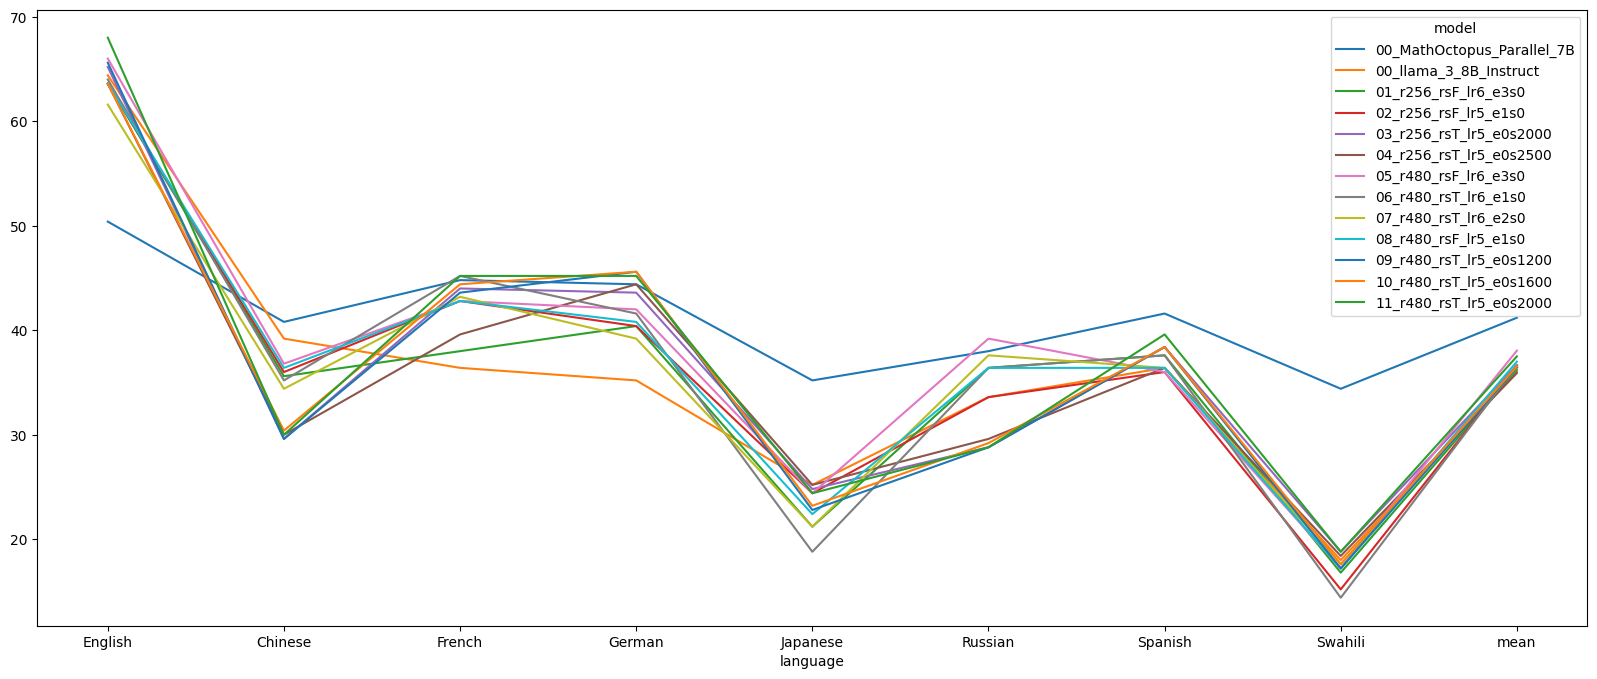

In [10]:
all_responses_df.T.plot(figsize=(20, 8))

## 7. Inference

In [ ]:
#----------------------------------------------------#
#@title Inference settings
#----------------------------------------------------#

model_selection = [
    '_model_MathOctopus_Parallel_7B',
    '_model_llama_3_8B_Instruct_meta',
    '_model_llama_3_8B_Instruct_meta_e3s0_b4_g4_r480_a1_lr1e-06_rslFalse',
    '_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue',
]

model_idx = 1
max_seq_length = 512
load_in_4bit=False


In [ ]:
#@title Copy of Initialization of model and tokenizer

def initialize(model_name, max_seq_length, load_in_4bit, dtype=None):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name, max_seq_length, dtype, load_in_4bit
    )

    tokenizer.padding_side = 'left'
    return model, tokenizer

In [ ]:
#@title Modified Inference function from above

def inference(model, tokenizer, instruction, language):
    FastLanguageModel.for_inference(model)

    # tokenizer.pad_token = tokenizer.eos_token
    # tokenizer.padding_side = 'left'
    # inputs = [inputs] if type(inputs) != list else inputs
    inputs = [alpaca_prompt.format(language=language, instruction=instruction, answer='')]
    inputs = tokenizer(inputs, return_tensors = 'pt', padding = False).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=128, do_sample=False, use_cache=True, temperature=0.00)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return decoded[0]

In [ ]:
model, tokenizer = initialize(model_name=model_selection[model_idx], max_seq_length=max_seq_length, load_in_4bit=load_in_4bit)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4127: RuntimeWarning: coroutine 'main' was never awaited
  gc.collect()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.
Please answer in the language of the instruction and do not make any translation if this language is not {language}.

### Instruction:
{instruction}

### Response:
{answer}"""

language = 'English'

In [ ]:
instruction = """У Маши было 16 яблок. 3 яблока она съела с подругами, 2 потеряла, а еще 5 скормила поросятам.
Сколько яблок осталось у Маши после того, как три она отадал Пете?"""

In [ ]:
response = inference(model, tokenizer, instruction, language)

In [ ]:
print(response[0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.  
Please answer in the language of the instruction and do not make any translation if this language is not English.

### Instruction:
У Маши было 16 яблок. 3 яблока она съела с подругами, 2 потеряла, а еще 5 скормила поросятам. 
Сколько яблок осталось у Маши после того, как три она отадал Пете?

### Response:
Маши было 16 яблок. Она съела 3, потеряла 2, скормила 5 поросятам. В итоге у неё осталось 16 - 3 - 2 - 5 = 6 яблок. Затем она отдала 3 яблока Пете. Осталось 6 - 3 = 3 яблока. 

### Translation:
Masha had 16 apples. She ate 3 with her friends, lost 2, and fed 5 to the piglets. In the end, she had 16 - 3 - 2 - 5 = 6 apples. Then she gave 3 apples to Pete. There were 6 - 3 = 3 apples left. 


In [ ]:
model, tokenizer = '', ''
free_memory((model, tokenizer), verbose=True)

## 8. Telegram bot

In [9]:
#@title Bot server code
%%writefile code/bot_server.py

import asyncio
import logging
import sys

from aiogram.client.bot import DefaultBotProperties
from aiogram import Bot, Dispatcher, Router, types
from aiogram.enums import ParseMode
from aiogram.filters import CommandStart
from aiogram.types import Message
from unsloth import FastLanguageModel, is_bfloat16_supported


#----------------------------------------------------#
#                      Settings                      #
#----------------------------------------------------#
token_path = 'code/bot_token.txt'
max_seq_length = 512
load_in_4bit = True
max_new_tokens = 256
do_sample = False # False for temperature 0.0
temperature = 0.00
use_cache = True

model_selection = [
    '_model_MathOctopus_Parallel_7B',
    '_model_llama_3_8B_Instruct_meta',
    '_model_llama_3_8B_Instruct_meta_e3s0_b4_g4_r480_a1_lr1e-06_rslFalse',
    '_model_llama_3_8B_Instruct_meta_e0s2000_b4_g4_r480_a1_lr1e-05_rslTrue',
]

model_idx = 3


intro_greeting = f"""Hi there, I am a Large Language Model based on Llama family by Meta AI.
{'-'*20}
I can solve school math tasks in English and some other languages. Let's give it a try and see what comes out! 🤓
"""

error_message = """Oops... I've pressed something and everything just broke down. 😬
Mind trying again?"""


alpaca_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.
Please give your response in the language of the instruction. Answer in {language} only if the following instruction is given in {language}

### Instruction:
{instruction}

### Response:
{answer}"""

language = "English"


split_delimiter = "### Response:\n"
hide_instruction = False
#----------------------------------------------------#


def initialize(model_name, max_seq_length, load_in_4bit, dtype=None):
    model, tokenizer = FastLanguageModel.from_pretrained(model_name, max_seq_length, dtype, load_in_4bit)
    model.generation_config.pad_token_ids = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    FastLanguageModel.for_inference(model)
    return model, tokenizer

def inference(model, tokenizer, instruction, language):
    inputs = [alpaca_prompt.format(language=language, instruction=instruction, answer='')]
    inputs = tokenizer(inputs, return_tensors = 'pt', padding = False).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=do_sample, use_cache=use_cache, temperature=temperature)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return decoded[0]


with open(token_path, 'r') as file: TOKEN = file.read().strip()

model, tokenizer = initialize(model_name=model_selection[model_idx], max_seq_length=max_seq_length, load_in_4bit=load_in_4bit)

dispatcher = Dispatcher()


@dispatcher.message(CommandStart())
async def command_handler(message: Message) -> None:
    await message.answer(intro_greeting)


@dispatcher.message()
async def echo_handler(message: types.Message) -> None:
    global hide_instruction
    if message.text == '/hide':
        hide_instruction = not hide_instruction
        await message.answer(f"Hide prompt instruction set to {hide_instruction}")
    elif message.text[0] == '/' and message.text[0] != '/hide':
        await command_handler(message)
    else:
        try:
            output = inference(model=model, tokenizer=tokenizer, instruction=message.text, language=language).replace("<<", "|").replace(">>", "|")
            await message.answer(output.split(split_delimiter)[1] if hide_instruction else output)
        except TypeError:
            await message.answer(error_message)


async def main() -> None:
    bot = Bot(TOKEN, default=DefaultBotProperties(parse_mode=ParseMode.HTML))
    await dispatcher.start_polling(bot)


if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, stream=sys.stdout)
    asyncio.run(main())

Overwriting code/bot_server.py


In [10]:
#@title Running the bot
!python code/bot_server.py

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
2024-06-03 15:07:15.793779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 15:07:15.793831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 15:07:15.795629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 15:07:16.950299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUD